<a href="https://colab.research.google.com/github/rajatgermany/yelp_elite_classifier/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
% matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score 
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)


from imblearn.over_sampling import (RandomOverSampler, SMOTE)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

from pyod.models.abod import ABOD
from pyod.models.knn import KNN 


warnings.filterwarnings('ignore')

In [0]:

# PLot settings
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [0]:
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/dataexploration/yelp/yelp_user.csv')

In [10]:
df.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


# Data Preprocessing

In [0]:
# Convert the yelping since with the number of years 

year_start_date = pd.to_datetime('20190101', format='%Y-%m-%d', errors='ignore')
df['yelping_since'] = pd.to_datetime(df.yelping_since)
df['yelping_years'] =  year_start_date - df.yelping_since
days = df['yelping_years'].astype('timedelta64[Y]')
df['yelping_years'] = df['yelping_years']/ np.timedelta64(1, 'Y')
df.drop('yelping_since', axis = 1, inplace = True)


In [0]:
df['elite'] = df.elite.apply(lambda x : 0 if x == 'None' else 1) # 1 if person is elite atleast for one year and 0 for if he/she never
df['friends'] = df.friends.apply(lambda x : 0 if x == None else len(x.split(',')) ) 

In [0]:
# Removed features which can be considered as ids

df.drop('name', axis = 1, inplace = True)
df.drop('user_id' , axis = 1, inplace = True)


# Target Variable

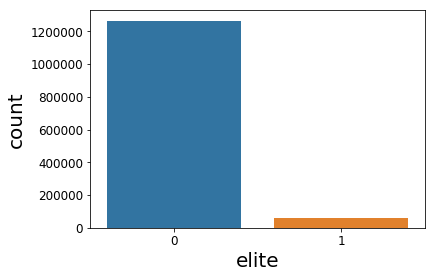

In [56]:
sns.countplot('elite', data = df)

# First Intuition

1. **Normal Classifier accuracy will not work for this solution . Because the classifer will be baised towards the majority class '0'**

2. **Because of this we will be classifying the minority class 1 as 0 most of the time**

3. **One solution is to collect more data for review count for class 1 which is not possibe in our case**

4. **Another solution is to perform undesampling or oversampling** . 

5. **OverSampling  adds copies of the minority class**

6.  **UnderSampling deletes the instances from the majority class**

<img src="https://drive.google.com/uc?export=download&id=1veIkl7Z9-iIqGF4KyFMv7bDKORsJqXAB">



# Approach

1. **I am not going to perform the oversampling here. Instead making a hypothesis on undersampling**

2. **I will sample our data using three undersampling techniques (KNearMiss, ClusterCentroid, RandomUnderSampler). Reason for choosing them solely on behalf of the computation nature of them. Other techniques are computionally epensive**

3. **I will be using recall as evaluation metric to score the classifier**
4. **Will perform the error analysis and try to find the patterns where classifier is failing.**
5. **We are here only concerned about the false positives . These will be the instances which are previously marked as '0' but classifier has marked Them '1'. Because in the context of the problem we don't want people who are not elite to be marked as elite. This is a business constraint I want to solve**

6. **Finally we will perform the feature enginerring using different methods**

# Sampling

In [0]:
# classifiers considered for the experiment
classifiers = {
    'Logistic': LogisticRegression(),
    'SVM': svm.SVC(gamma='auto'),
    "Random_forest": RandomForestClassifier(n_estimators=100, 
                                            max_depth=2,
                                            random_state=0)
}

In [0]:
y = df.elite
X = df.drop('elite', axis =1)

In [0]:

# User defined functions
def kfold_score(X, Y, fold):
  """ Returns the average recall score per cross each fold for each classifier.

    Parameters:
        X (ndarray): DataFrame is converted to ndarry by sampling methods.
        Y (array): Target Variable

    Returns:
        reverse(str1):The string which gets reversed.   

    """
  
  kfold = model_selection.KFold(n_splits = fold, shuffle=True)
  
  result = dict()
  for classifer_name, classifer in classifiers.items():
    final_score = 0

    for i, (train_index, test_index) in enumerate(kfold.split(X)):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      classifer.fit(X_train, y_train)
      y_pred = classifer.predict(X_test)
      

      final_score += recall_score(y_test, y_pred)  

    result.update({classifer_name: (final_score/fold) * 100}) 
    
  return result 


def sampling(sampling_technique, ratio):
  sampler = sampling_technique(ratio=ratio, sampling_strategy = 'minority')
  X_sample, y_sample = sampler.fit_resample(X, y)
  
  return (X_sample, y_sample)


def get_recall_score(sampling_technique, ratio, fold):
  
    X_sample, y_sample = sampling(sampling_technique, ratio)
    return kfold_score(X_sample, y_sample, fold)




In [0]:
# Ratios of the samples considered in the experiments

experiment_ratios = [
    {
        0: 25,
        1: 25
    },
     {
        0: 50,
        1: 25
    },
     {
        0: 75,
        1: 25
    },
     {
        0: 125,
        1: 25
    },
     {
        0: 250,
        1: 25
    }
]

## Sampling Techniques

Generate Samples using different undersampling techniques

In [0]:
# Near Miss Technique
sampled_df_NearMiss = pd.DataFrame()
for ratio in experiment_ratios:
  sampled_df_NearMiss = sampled_df_NearMiss.append(get_recall_score(NearMiss, ratio, 10), ignore_index=True)
  
sampled_df_NearMiss = sampled_df_NearMiss.T
sampled_df_NearMiss.columns = [1, 2, 3,5, 10] # majority class ratio
sampled_df_NearMiss # recall score for different ratio

In [18]:
sampled_df_NearMiss

,1,2,3,5,10
Logistic,55.833333,57.500000,55.000000,42.500000,14.523810
Random_forest,78.000000,51.500000,35.333333,20.333333,3.333333
SVM,81.666667,69.166667,49.166667,30.833333,10.000000


**Recall Score for different ratio of class 0**

In [0]:
# Random UnderSampler
sampled_df_RandomSampler = pd.DataFrame()

for ratio in experiment_ratios:
  sampled_df_RandomSampler = sampled_df_RandomSampler.append(get_recall_score(RandomUnderSampler, ratio, 10), ignore_index=True)
  
sampled_df_RandomSampler = sampled_df_RandomSampler.T
sampled_df_RandomSampler.columns = [1, 2, 3,5, 10]
sampled_df_RandomSampler


In [20]:
sampled_df_RandomSampler

,1,2,3,5,10
Logistic,87.500000,95.5,58.5,77.5,60.666667
Random_forest,88.333333,85.0,72.0,83.0,48.333333
SVM,100.000000,80.0,0.0,0.0,0.000000


In [0]:
# ClusterCentroid
sampled_df_ClusterCentroid = pd.DataFrame()
for ratio in experiment_ratios:
  sampled_df_ClusterCentroid = sampled_df_ClusterCentroid.append(get_recall_score(ClusterCentroids, ratio, 10), ignore_index=True)
  
sampled_df_ClusterCentroid = sampled_df_ClusterCentroid.T
sampled_df_ClusterCentroid.columns = [1, 2, 3,5, 10]
sampled_df_ClusterCentroid


In [15]:
sampled_df_ClusterCentroid

,1,2,3,5,10
Logistic,70.000000,73.333333,60.333333,51.666667,58.333333
Random_forest,71.666667,82.333333,75.833333,61.666667,60.000000
SVM,30.000000,0.000000,0.000000,0.000000,0.000000


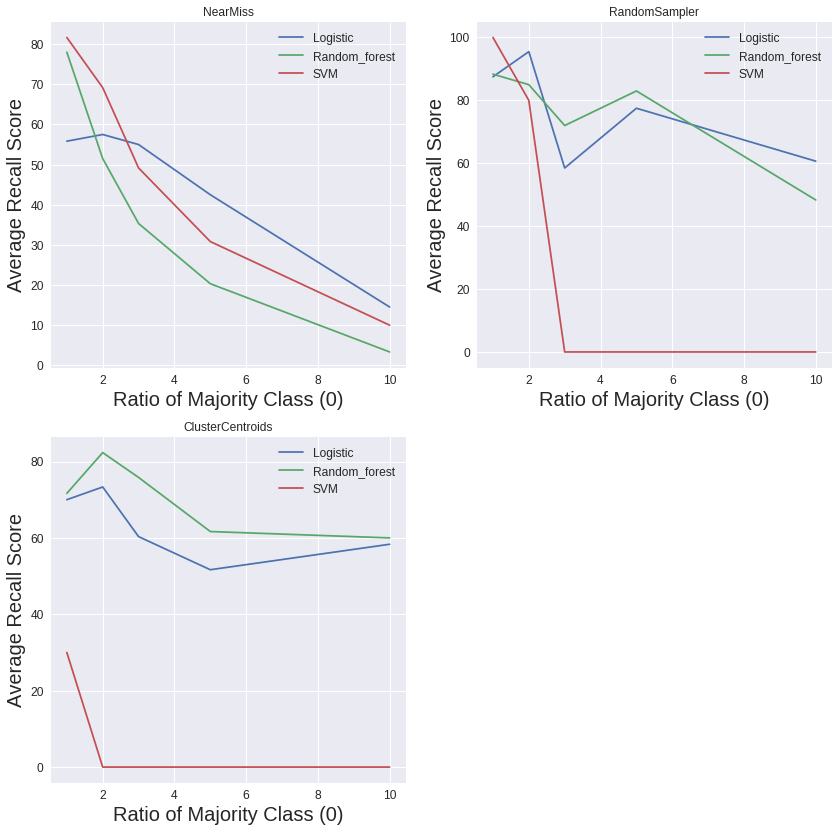

In [22]:
from scipy.stats import norm
fig, ax = plt.subplots(2,2, figsize=(14, 14))

sampled_df_NearMiss.T.plot(ax = ax[0][0])
sampled_df_RandomSampler.T.plot(ax = ax[0][1])
sampled_df_ClusterCentroid.T.plot(ax = ax[1][0])

ax[0][0].set_xlabel('Ratio of Majority Class (0)')
ax[0][0].set_ylabel('Average Recall Score')
ax[0][0].set_title('NearMiss')

ax[0][1].set_xlabel('Ratio of Majority Class (0)')
ax[0][1].set_ylabel('Average Recall Score')
ax[0][1].set_title('RandomSampler')


ax[1][0].set_xlabel('Ratio of Majority Class (0)')
ax[1][0].set_ylabel('Average Recall Score')
ax[1][0].set_title('ClusterCentroids')


ax[1][1].set_visible(False)

**Findings**

1.   RandomUnderSampling has performed the best,  shown least variance in the ratios
2.   Logistic Regression and Random Forest both better then the SVM
3.   Ratio 5 is a intresting case. As the recall score increase at this sampling after the dip



# Error Analysis


**For generating the basline** .

1. Consider the logistic regresison because it is simpler then the RandomFOREST 

2.  Used the sampling ratio 5 purely based on recall score of logistic Regression it performed better then the 3

In [0]:
def kfold_false_predictions(df,fold, type_of_wrong_instance):
  
  X = df.drop('elite', axis= 1)
  Y = df.elite
    
  kfold = model_selection.KFold(n_splits = fold, shuffle=True)
  model = LogisticRegression()
  
  final_score = 0
  for i, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    final_score += recall_score(y_test, y_pred)

    # Converted to find the indices of the false predicted instance
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    label = 0 if type_of_wrong_instance == 'false_positive' else 1
    
    false_indices = [i for i in list(y_test.index) if y_test.loc[i] == label and y_test.loc[i]  != y_pred.loc[i]]
    
    
    
    if len(false_indices) != 0:
      print(X_test.loc[false_indices[0]])
 
 

In [0]:
# Sampled data using RandomSampler is created for ratio {0:150, 1:25}

X_sample, y_sample = sampling(NearMiss , ratio = {0:150, 1:25})
sampled_df_randomSampler = pd.DataFrame(X_sample, columns = X.columns)
sampled_df_randomSampler['elite'] = y_sample
sampled_df_randomSampler = shuffle(sampled_df_randomSampler)
sampled_df_randomSampler.reset_index(drop= True)

In [20]:
sampled_df_randomSampler.shape

(175, 20)

In [28]:
# finding the false positives
kfold_false_predictions(sampled_df_randomSampler, 10, 'false_positive')

review_count          28.000000
friends                1.000000
useful                 1.000000
funny                  0.000000
cool                   0.000000
fans                   1.000000
average_stars          4.100000
compliment_hot         0.000000
compliment_more        0.000000
compliment_profile     0.000000
compliment_cute        0.000000
compliment_list        0.000000
compliment_note        0.000000
compliment_plain       0.000000
compliment_cool        0.000000
compliment_funny       0.000000
compliment_writer      0.000000
compliment_photos      0.000000
yelping_years          1.511325
Name: 82, dtype: float64
review_count          71.000000
friends                1.000000
useful                 0.000000
funny                  0.000000
cool                   0.000000
fans                   1.000000
average_stars          4.500000
compliment_hot         0.000000
compliment_more        0.000000
compliment_profile     0.000000
compliment_cute        0.000000
compliment_list

**First thing comes to mind is checking if these records are the outlier in the dataset**

We will evaluate extreme analysis on review count

## Outlier Analysis

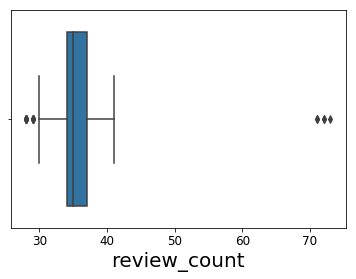

In [34]:
sns.boxplot(sampled_df_randomSampler[sampled_df_randomSampler.elite == 0].review_count)


In [30]:
sampled_df_randomSampler[sampled_df_randomSampler.elite == 0].describe()


,review_count,friends,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,yelping_years,elite
count,150.000000,150.000000,150.000000,150.0,150.0,150.000000,150.000000,150.0,150.0,150.0,150.0,150.0,150.000000,150.0,150.0,150.0,150.000000,150.0,150.000000,150.0
mean,35.873333,1.006667,0.033333,0.0,0.0,0.060000,4.007667,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.013333,0.0,4.733677,0.0
std,7.405147,0.081650,0.180107,0.0,0.0,0.238282,0.291505,0.0,0.0,0.0,0.0,0.0,0.140469,0.0,0.0,0.0,0.115082,0.0,1.498945,0.0
min,28.000000,1.000000,0.000000,0.0,0.0,0.000000,3.210000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.251224,0.0
25%,34.000000,1.000000,0.000000,0.0,0.0,0.000000,3.805000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,3.480564,0.0
50%,35.000000,1.000000,0.000000,0.0,0.0,0.000000,4.030000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.107566,0.0
75%,37.000000,1.000000,0.000000,0.0,0.0,0.000000,4.217500,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.893345,0.0
max,73.000000,2.000000,1.000000,0.0,0.0,1.000000,4.690000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,7.334853,0.0


**Lets check first by statiscally if the values are extremes**

Lets check the distrobution of the review_count

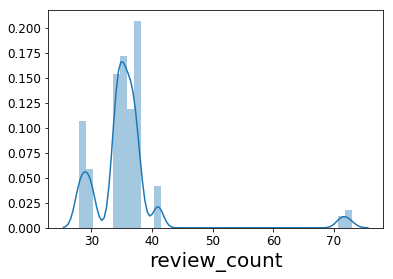

In [31]:
sns.distplot(sampled_df_randomSampler[sampled_df_randomSampler.elite == 0].review_count)

Clearly it a long tail 

lets calulate the probablitity of the instances recored as false positives

In [32]:
import scipy.stats as st
Z_score = (1- 35.8) / 28.0
Z_score
st.norm.cdf(Z_score)

0.10696024046494751

In [33]:
Z_score = (71- 35.8) / 28.0
Z_score
st.norm.cdf(Z_score)

0.8956490446638217

**Both the instances are quite exteme values**

## Machine learning Anamoly detection

In [0]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN 

anamoly_detector = {
     'ABOD'   : ABOD(contamination=0.1),
     'KNN' :  KNN(contamination=0.1)
}

In [0]:
def outliers_detection(anamoly_detector, sampled_df_randomSampler):
  sampled_df_randomSampler = sampled_df_randomSampler.reset_index(drop = True)
 
  anamoly_detector.fit(sampled_df_randomSampler)
  y_pred = anamoly_detector.predict(sampled_df_randomSampler)
  y_pred[y_pred == -1] = 1 # for the invalid entry
  y_pred[y_pred == 1] = 0 # for the valid entry
  print(y_pred)

In [39]:
outliers_detection(anamoly_detector['ABOD'], sampled_df_randomSampler)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
outliers_detection(anamoly_detector['KNN'], sampled_df_randomSampler)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Both the algorithms not able to find the outliers**

# Model Tuning

In [41]:
sampled_df_randomSampler.elite.value_counts()

0    150
1     25
Name: elite, dtype: int64

## Feature Selection

In [0]:
# Logistic Regression is selected for the  baseline
X_sampled = sampled_df_randomSampler.drop('elite', axis = 1)
y_sampled = sampled_df_randomSampler.elite

classifier = LogisticRegression()
baseline_score = cross_val_score(classifier, X_sampled, y_sampled, cv=10, scoring = 'recall').mean()


In [43]:
y_sampled.value_counts()

0    150
1     25
Name: elite, dtype: int64

# This helps us to find the effect of feature selection

In [0]:
def calculate_change_in_recall(X):
  return cross_val_score(classifier, X, y_sampled, cv=10, scoring = 'recall').mean() - baseline_score


### Correlation

In [45]:
sampled_df_randomSampler.corr().elite

review_count          0.250186
friends               0.502794
useful                0.145199
funny                      NaN
cool                       NaN
fans                  0.462100
average_stars        -0.007426
compliment_hot        0.374634
compliment_more       0.185695
compliment_profile         NaN
compliment_cute            NaN
compliment_list            NaN
compliment_note       0.126025
compliment_plain      0.185695
compliment_cool       0.263371
compliment_funny      0.263371
compliment_writer     0.282051
compliment_photos          NaN
yelping_years        -0.332993
elite                 1.000000
Name: elite, dtype: float64

In [0]:
df_with_high_corr = sampled_df_randomSampler[[ 'friends', 'fans', 'compliment_hot', 'yelping_years', 'elite']].reset_index(drop= True)

In [0]:
X_corr = df_with_high_corr.drop('elite',axis =1)


In [49]:
calculate_change_in_recall(X_corr)

-0.11666666666666659

### RFE

In [50]:
classifier = RandomForestClassifier(n_estimators=100, 
                                            max_depth=2,
                                           random_state=0)
rfe = RFE(classifier, 12 )
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_sampled,y_sampled) 
X_rfe.shape

(175, 12)

In [51]:
calculate_change_in_recall(X_rfe)

-0.24999999999999994

### Esemble 

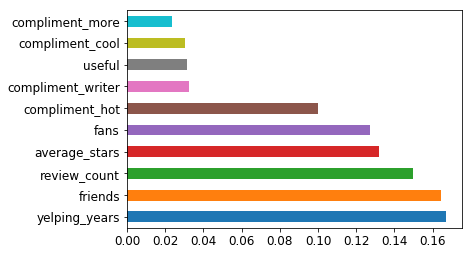

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_sampled,y_sampled) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

In [0]:
important_10_features = list(feat_importances.nlargest(10).index)
X_important_features = X_sampled[important_10_features]

In [54]:
calculate_change_in_recall(X_important_features)

-0.16666666666666663

# Findings 

1. CLearly this problem is the case of the anamoly detection
2. Classifers even with the feature selection not able to improve the recall score
3. We need to do more outlier analysis on the dataset and also try on diffeerent unsampling techniques